## Imports

In [1]:
import os
current_file_dir = os.getcwd()
os.chdir("../../codes/")

from src.load_explanations import load_explanations_of_many_models, _unify_lenths, _trim_image_path
from src import strings_to_classes_mappings
from src import utils


from src.compare_explanations import compare_explanations, cosine_similarity_distance_with_stdev_and_mean, radial_basis_function_distance_with_stdev_and_mean

os.chdir(current_file_dir)

# Usage example

Get possible models etc.

In [2]:
print("Possible datasets:", list(strings_to_classes_mappings.datasets_mapping.keys()))
print("Possible models:", list(strings_to_classes_mappings.models_mapping.keys()))
print("Possible explanations:", list(strings_to_classes_mappings.explanations_mapping.keys()))
models_list = list(strings_to_classes_mappings.models_mapping.keys())

Possible datasets: ['imagenette2']
Possible models: ['ConvNeXtV2_Nano', 'DeiT_S', 'DeiT_T', 'DenseNet121', 'EfficientNet_B3', 'EfficientNet_B4', 'MobileNetV3', 'PyramidViT_V2_B2', 'Res2Net50', 'ResNet18', 'ResNet50', 'ResNeXt50', 'Swin_T', 'ViT_B_32']
Possible explanations: ['GradCAM', 'IntegratedGradients', 'KernelSHAP']


# Getting data

In [3]:
paths_to_explanations = {
    "GradCAM" : os.path.join(current_file_dir, os.pardir, "20240410-gradcam-1024", 'explanations'),
}

In [4]:
explanations_many_models = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=paths_to_explanations['GradCAM'])

Loading explanations:   0%|          | 0/1024 [00:00<?, ?it/s]

Loading explanations: 100%|██████████| 1024/1024 [00:01<00:00, 602.23it/s]


Loaded 1024 common explanations for each model.


In [5]:
explanations_many_models[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions'])

In [6]:
explanations_many_models[0]['explanation_name']

'GradCAM'

In [7]:
explanations_many_models[0]['paths'][0]

't:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240806-influence-of-images-count\\..\\20240410-gradcam-1024\\explanations\\imagenette2\\GradCAM\\ConvNeXtV2_Nano\\n01440764\\ILSVRC2012_val_00000293.npy'

In [8]:
len(explanations_many_models)

14

In [9]:
explanations_many_models[0]['explanations'].shape

torch.Size([1024, 224, 224])

---

In [10]:
similarity_df_rbf = compare_explanations(explanations_many_models, comparison_function=radial_basis_function_distance_with_stdev_and_mean)
# similarity_df_rbf.to_csv(os.path.join(current_file_dir, "dissimilarity_matrix_gradcam_rbf.csv"))
similarity_df_cosine = compare_explanations(explanations_many_models, comparison_function=cosine_similarity_distance_with_stdev_and_mean)
# similarity_df_cosine.to_csv(os.path.join(current_file_dir, "dissimilarity_matrix_gradcam_cosine.csv"))

In [11]:
(similarity_df_rbf - similarity_df_cosine).sum().sum()

-21.77636570267341

In [12]:
import numpy as np

def sample_n_of_all_explanations(all_explanations, n):
    # all_explanations is a list of dicts with keys 'explanations'
    # randomly samples n indices of explanations to leave
    # for each item in all_explanations return the same n indices
    n_explanations = all_explanations[0]['explanations'].shape[0]
    n = min(n, n_explanations)
    indices = np.random.choice(range(n_explanations), n, replace=False)
    return [{**explanation, 'explanations': explanation['explanations'][indices]} for explanation in all_explanations]

In [13]:
n = 10
explanations_many_models_sampled = sample_n_of_all_explanations(explanations_many_models, n)
explanations_many_models_sampled[0]['explanations'].shape

torch.Size([10, 224, 224])

In [14]:
# get similarity matrices m times for n samples
def get_similarity_matrices_m_times_for_n_samples(all_explanations, n, m, comparison_function):
    similarity_matrices = []
    for i in range(m):
        explanations_many_models_sampled = sample_n_of_all_explanations(all_explanations, n)
        similarity_matrices.append(compare_explanations(explanations_many_models_sampled, comparison_function=comparison_function))
    return similarity_matrices

In [15]:
n = 5
m = 10
similarity_matrices_rbf = get_similarity_matrices_m_times_for_n_samples(explanations_many_models, n, m, radial_basis_function_distance_with_stdev_and_mean)
len(similarity_matrices_rbf), similarity_matrices_rbf[0].shape

(10, (14, 14))

In [16]:
# compute variance for each cell of the matrix 
variance_matrix_rbf = np.var(similarity_matrices_rbf, axis=0)
# take upper half and flatten
variance_matrix_rbf = np.triu(variance_matrix_rbf, k=1).flatten()
variance_matrix_rbf = variance_matrix_rbf[variance_matrix_rbf != 0]
variance_matrix_rbf.shape

(91,)

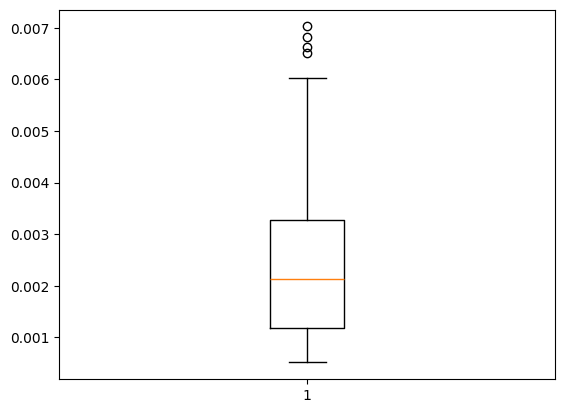

In [17]:
# boxplot of variance
import matplotlib.pyplot as plt

plt.boxplot(variance_matrix_rbf)
plt.show()

In [18]:
def get_variances_list(explanations_many_models, n_list, m, similarity_metric):
    results = []
    for n in n_list:
    # for n in [10, 30, 60]:
        similarity_matrices_rbf = get_similarity_matrices_m_times_for_n_samples(explanations_many_models, n, m, similarity_metric)
        variance_matrix_rbf = np.triu(np.var(similarity_matrices_rbf, axis=0), k=1).flatten()
        variance_matrix_rbf = variance_matrix_rbf[variance_matrix_rbf != 0]
        for variance in variance_matrix_rbf:
            results.append({'n': n, 'variance': variance})
    return results

def get_results_sums(explanations_many_models, n_list, m, similarity_metric, all_images_results):
    results_sums = []
    for n in n_list:
    # for n in [10, 30, 60]:
        similarity_matrices_rbf = get_similarity_matrices_m_times_for_n_samples(explanations_many_models, n, m, similarity_metric)
        for similarity_matrix_rbf in similarity_matrices_rbf:
            results_sums.append({'n': n, 'sum': abs(similarity_matrix_rbf - all_images_results).sum().sum()/2}) # /2 because matrix is symmetric
    return results_sums

In [19]:
fontsize_labels = 14
fontsize_title = 14
figsize = (5,3)
dpi = 300

### rbf

In [20]:
n_list = [25, 50, 75, 100, 200, 300, 400, 500]
m = 10
similarity_metric = radial_basis_function_distance_with_stdev_and_mean

results = get_variances_list(explanations_many_models, n_list, m, similarity_metric)

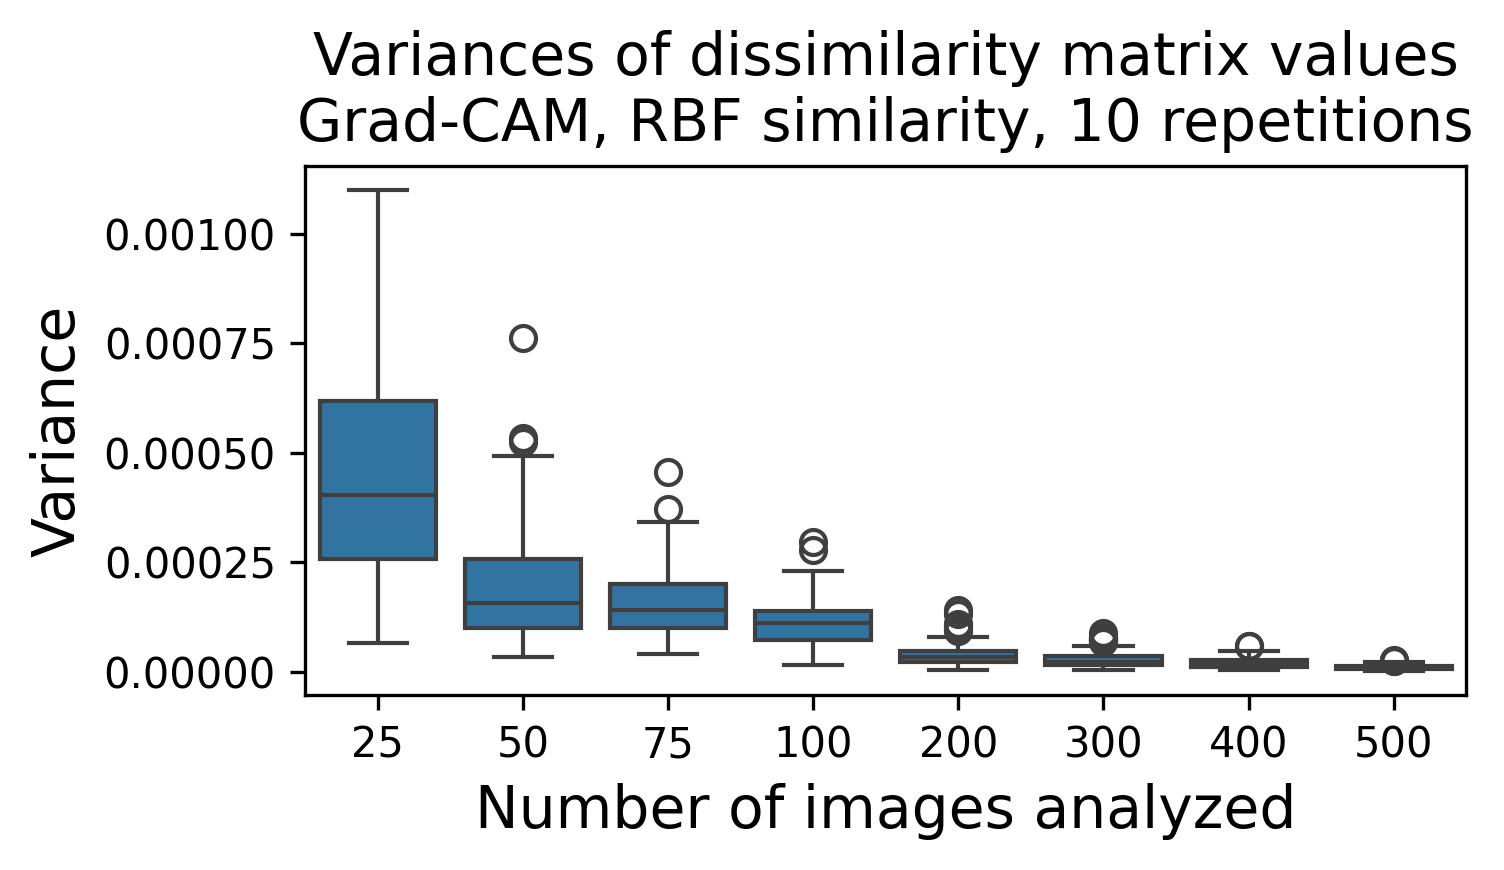

In [21]:
# plot variance
import seaborn as sns
import pandas as pd

method_name = 'RBF' if similarity_metric == radial_basis_function_distance_with_stdev_and_mean else 'cosine'

results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.boxplot(x='n', y='variance', data=results_df, ax=ax)
plt.title(f'Variances of dissimilarity matrix values\nGrad-CAM, {method_name} similarity, {m} repetitions', fontsize=fontsize_title)
# ax.set_yscale('log')
# plot x and y labels
plt.xlabel('Number of images analyzed', fontsize=fontsize_labels)
plt.ylabel('Variance', fontsize=fontsize_labels)
plt.tight_layout()
plt.savefig(os.path.join(current_file_dir, f"variance_boxplot_gradcam_{method_name.lower()}.png"))
plt.show()

In [22]:
# average total sum of abs differences between matrices computed for n samples and 1000 samples matrix
all_images_results = get_similarity_matrices_m_times_for_n_samples(explanations_many_models, 1000, 1, similarity_metric)
all_images_results = all_images_results[0]

In [23]:
# average total sum of abs differences between matrices computed for n samples and 1000 samples matrix
results_sums = get_results_sums(explanations_many_models, n_list, m, similarity_metric, all_images_results)

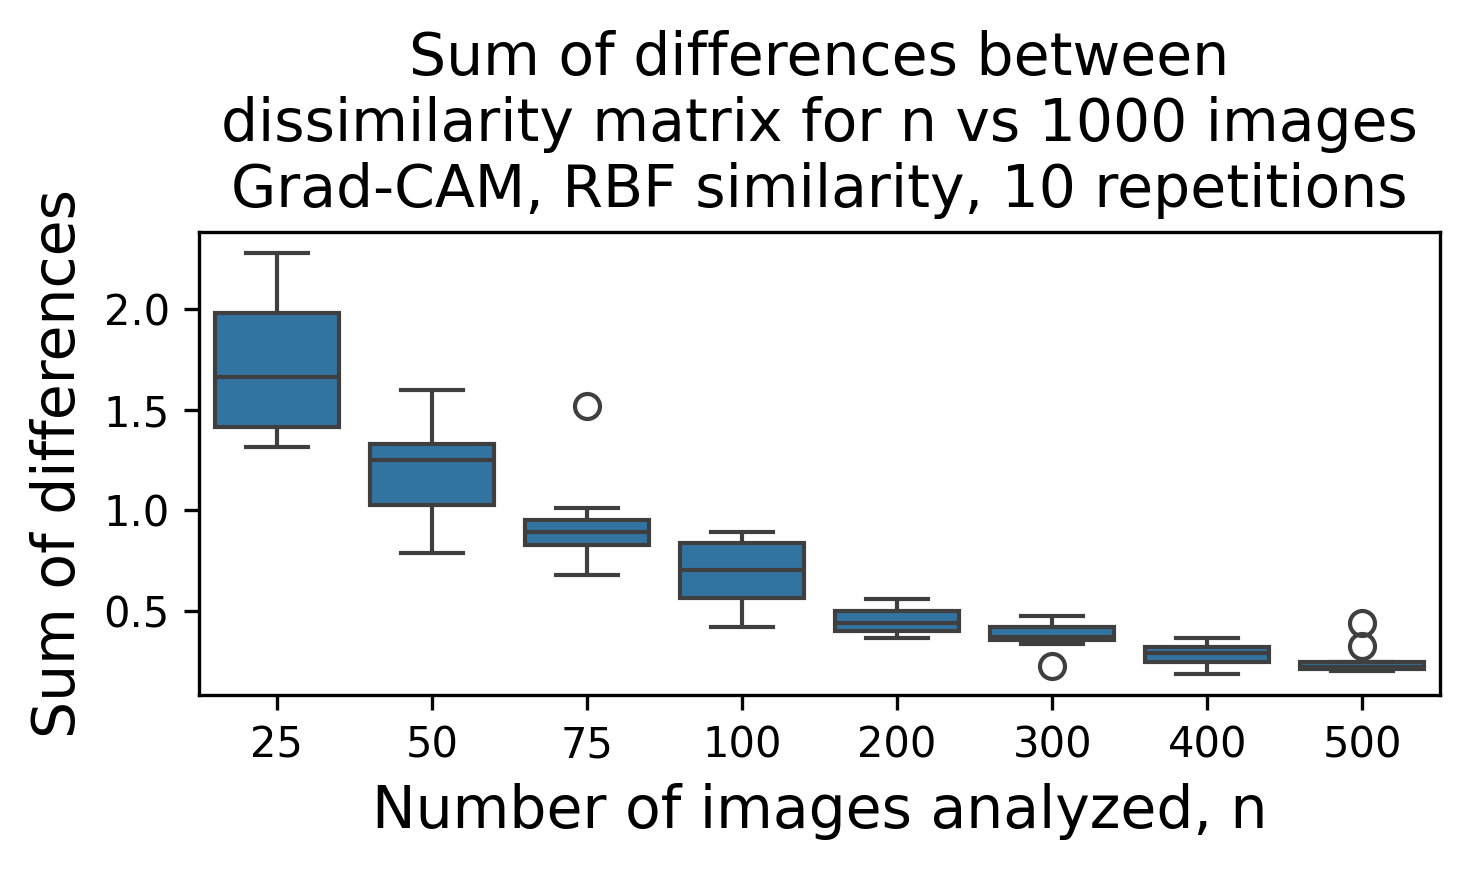

In [24]:
# plot variance
import seaborn as sns
import pandas as pd

method_name = 'RBF' if similarity_metric == radial_basis_function_distance_with_stdev_and_mean else 'cosine'

results_df = pd.DataFrame(results_sums)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.boxplot(x='n', y='sum', data=results_df, ax=ax)
plt.title(f'Sum of differences between\ndissimilarity matrix for n vs 1000 images\nGrad-CAM, {method_name} similarity, {m} repetitions', fontsize=fontsize_title)
# plot x and y labels
plt.xlabel('Number of images analyzed, n', fontsize=fontsize_labels)
plt.ylabel('Sum of differences', fontsize=fontsize_labels)
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(current_file_dir, f"sum_difference_boxplot_gradcam_{method_name.lower()}.png"))
plt.show()

### cosine

In [25]:
n_list = [25, 50, 75, 100, 200, 300, 400, 500]
m = 25
similarity_metric = cosine_similarity_distance_with_stdev_and_mean

results = get_variances_list(explanations_many_models, n_list, m, similarity_metric)

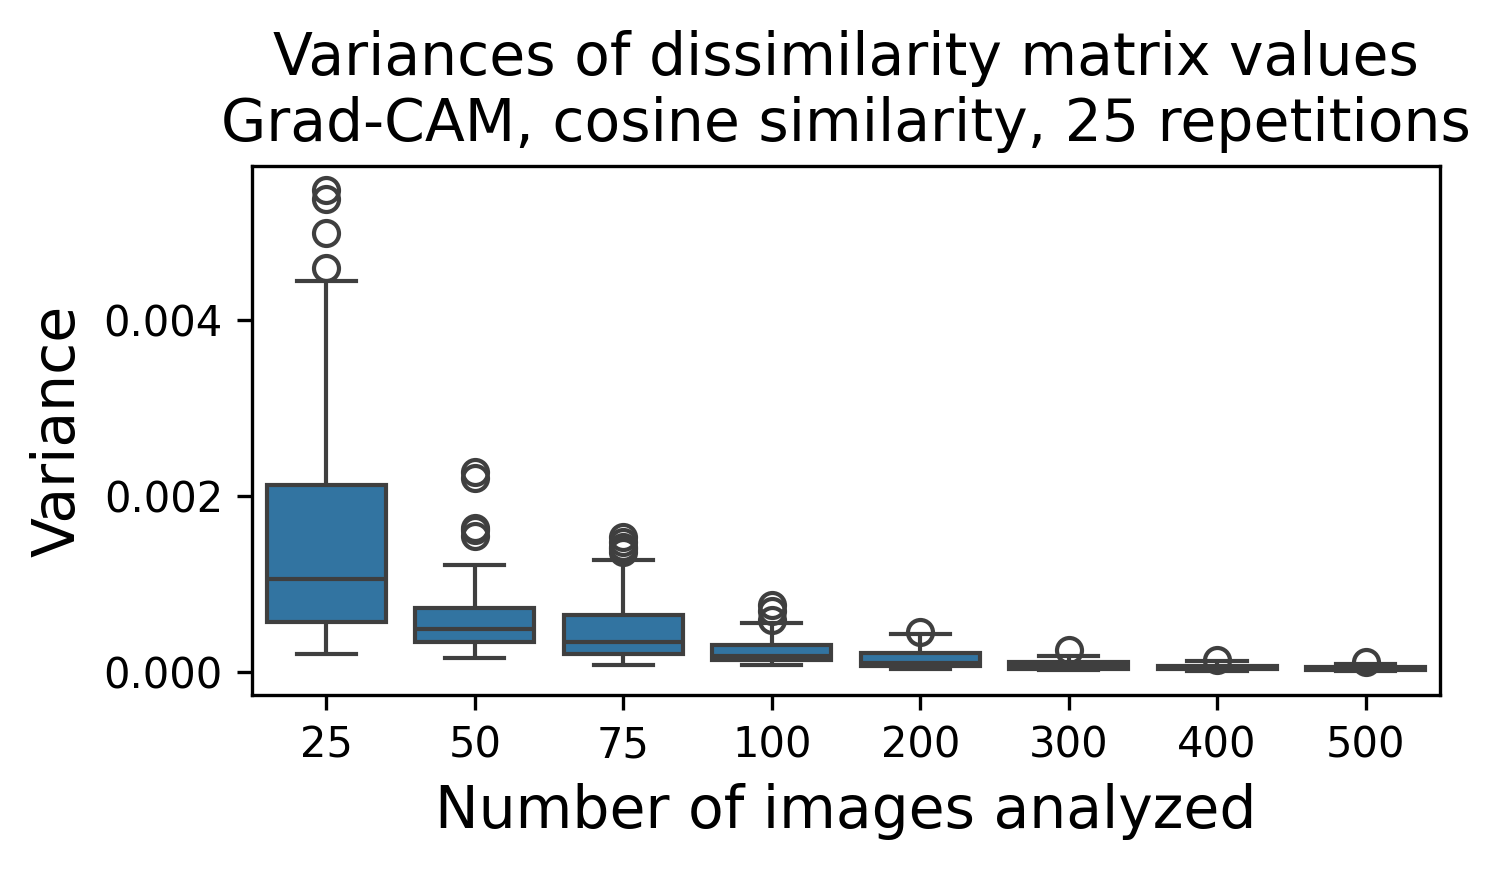

In [26]:
# plot variance
import seaborn as sns
import pandas as pd

method_name = 'RBF' if similarity_metric == radial_basis_function_distance_with_stdev_and_mean else 'cosine'

results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.boxplot(x='n', y='variance', data=results_df, ax=ax)
plt.title(f'Variances of dissimilarity matrix values\nGrad-CAM, {method_name} similarity, {m} repetitions', fontsize=fontsize_title)
# ax.set_yscale('log')
# plot x and y labels
plt.xlabel('Number of images analyzed', fontsize=fontsize_labels)
plt.ylabel('Variance', fontsize=fontsize_labels)
plt.tight_layout()
plt.savefig(os.path.join(current_file_dir, f"variance_boxplot_gradcam_{method_name.lower()}.png"))
plt.show()

In [27]:
# average total sum of abs differences between matrices computed for n samples and 1000 samples matrix
all_images_results = get_similarity_matrices_m_times_for_n_samples(explanations_many_models, 1000, 1, similarity_metric)
all_images_results = all_images_results[0]

In [28]:
# average total sum of abs differences between matrices computed for n samples and 1000 samples matrix
results_sums = get_results_sums(explanations_many_models, n_list, m, similarity_metric, all_images_results)

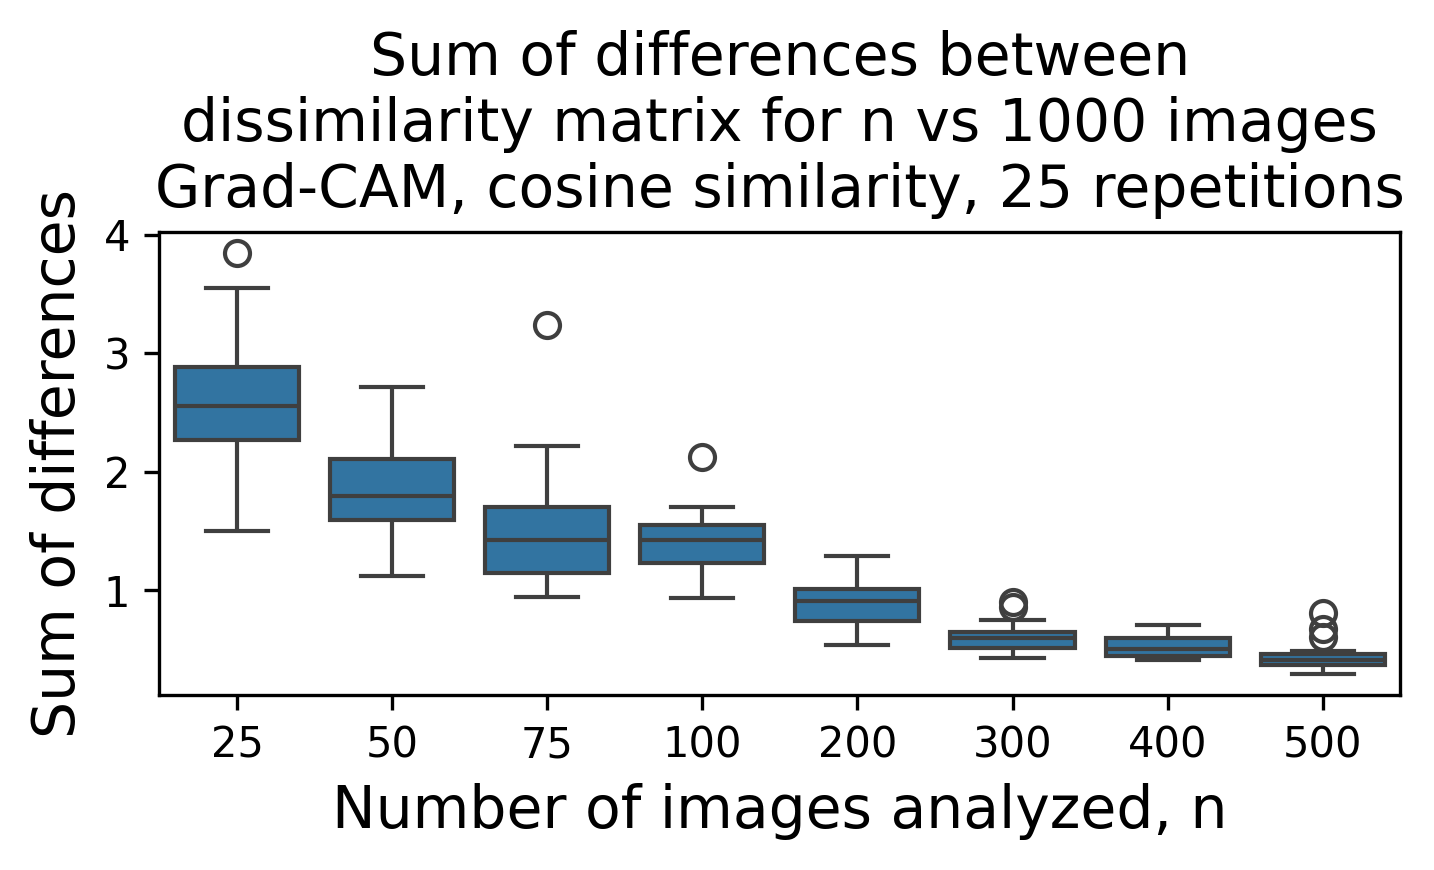

In [29]:
# plot variance
import seaborn as sns
import pandas as pd

method_name = 'RBF' if similarity_metric == radial_basis_function_distance_with_stdev_and_mean else 'cosine'

results_df = pd.DataFrame(results_sums)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.boxplot(x='n', y='sum', data=results_df, ax=ax)
plt.title(f'Sum of differences between\ndissimilarity matrix for n vs 1000 images\nGrad-CAM, {method_name} similarity, {m} repetitions', fontsize=fontsize_title)
# plot x and y labels
plt.xlabel('Number of images analyzed, n', fontsize=fontsize_labels)
plt.ylabel('Sum of differences', fontsize=fontsize_labels)
plt.tight_layout()
# ax.set_yscale('log')
plt.savefig(os.path.join(current_file_dir, f"sum_difference_boxplot_gradcam_{method_name.lower()}.png"))
plt.show()